In [8]:
import librosa
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from numpy.core.umath_tests import inner1d
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# video==>audio ==> silence ==>silence_MP4_480_1_5MG.mp4 ==> audio_silence.wav
# ffmpeg -i C:/Users/Hanane/Documents/Python_Scripts/TelecomParis/Module_4_Donnees_Multimedia/sample_audio/silence_MP4_480_1_5MG.mp4 -ab 160k -ac 2 -ar 44100 -vn audio_silence.wav
    
# audio ==> musique ==> audio_music_WAV_1MG.wav, audio_music_MP3_1MG.mp3

# ffmpeg -i C:/Users/Hanane/Downloads/alors.mov -ab 160k -ac 2 -ar 44100 -vn audio_speech_alors.wav
    
# ffmpeg -i C:/Users/Hanane/Downloads/gros_loup_et_la_petite_bête.mov -ab 160k -ac 2 -ar 44100 -vn audio_speech_gros_loup.wav

# path_file="../sample_audio/file_example_WAV_1MG.wav"
# y, sr = librosa.load(path_file)

## METHODS

### METHODS-GENERATE FEATURES

In [658]:
def generate_features(path_file,frame_length,hop_length):
    y, sr = librosa.load(path_file)
#     print("y shape=",y.shape,"sample_rate=",sr)
    mfcc_music=librosa.feature.mfcc(y=y, sr=sr,win_length=frame_length,hop_length=hop_length, n_mfcc=13)
    d_mfcc_music = delta(mfcc_music, 2)
    
    columns=['mfcc'+str(i) for i in range(1,14)]
    df_mfcc_music=pd.DataFrame(data=mfcc_music.T,columns=columns)

    columns=['d_mfcc'+str(i) for i in range(1,14)]
    df_delta_mfcc_music=pd.DataFrame(data=d_mfcc_music.T,columns=columns)

    df_global=pd.concat([df_mfcc_music,df_delta_mfcc_music],axis=1,sort=True)
#     print("final_df shape=",df_global.shape)
    return df_global

def delta(feat, N):
    """Compute delta features from a feature vector sequence.
    :param feat: A numpy array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
    :param N: For each frame, calculate delta features based on preceding and following N frames
    :returns: A numpy array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
    """
    if N < 1:
        raise ValueError('N must be an integer >= 1')
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feat = np.empty_like(feat)
    padded = np.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat

### METHODS-RUN MODELS

In [563]:
def run_model_test(df_speech,df_music,df_silence,frame_length,hop_length,window_avg):
    print("************ BUILD DATASET ************")
    df_speech['label']=1
    df_music['label']=2
    df_silence['label']=0
    df_all=pd.concat([df_speech,df_music,df_silence],ignore_index=True)
    print("df_all shape",df_all.shape)
    print("DATASET ALL label count",df_all.groupby('label')['label'].count())
    
    print("************ SPLIT TRAIN AND TEST ************")
    X=df_all.iloc[:,:-1]
    y=df_all.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    print("DATASET TEST label count",pd.DataFrame(data=y_test).groupby("label")['label'].count())

    print("************ FIT MODEL ON TRAIN AND PREDICT - ACCURACY SCORE ************")
    clf = GradientBoostingClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print("clf.score",clf.score(X_test, y_test))

    print("accuracy_score",accuracy_score(y_test,y_pred))
    print("confusion_matrix", confusion_matrix(y_test,y_pred))
    
    print("************ APLLY MODEL TO OUR AUDIO ************")
    df_res=test_audio(clf,frame_length,hop_length,window_avg)
    return df_res

def test_audio(clf,frame_length,hop_length,window_avg):
    file_name="mfcc_generique_reportage"+str(frame_length)+"_"+str(hop_length)+".csv"
    df=pd.read_csv(file_name)
    df=df.drop(columns=['Unnamed: 0'])
    print("SHAPE OUR AUDIO ", df.shape)
    y_pred=clf.predict(df)
    df_y=pd.DataFrame(data=y_pred,columns=['label'])
    print("Pred label count",df_y.groupby('label')['label'].count())

    df_res=pd.concat([df,df_y],axis=1,sort=True)
    df_res['avg_res']=df_res['label'].rolling(window=window_avg).mean() #par second
    df_res['proba_2']=clf.predict_proba(df)[:,2]
    df_res['avg_proba_2']=df_res['proba_2'].rolling(window=window_avg).mean()
    print("Final resulat",df_res.shape)
    
    plt.title("MVA 1s proba class 2")
    df_res['avg_proba_2'].plot()
    plt.show()
    df_res.loc[0:1500,'avg_proba_2'].plot()
    plt.show()
    return df_res

def get_right_index_time(df_res,col,wind_diff):
    max_jump=np.max(df_res[col].diff(wind_diff))
    min_jump=np.min(df_res[col].diff(wind_diff))
    arr_max_min=np.abs([max_jump,min_jump])
    max_v=np.max(arr_max_min)
    max_idx=np.where(arr_max_min==max_v)[0][0]
    if max_idx==0:
        idx_reportage=np.where(df_res[col].diff(wind_diff)==max_jump)
    if max_idx==1:
        idx_reportage=np.where(df_res[col].diff(wind_diff)==min_jump)
    plt.plot(df_res[col].diff(wind_diff)[:2000],label=wind_diff)
    plt.legend()
    return idx_reportage[0][0]

## GLOBAL PARAMETERS

In [555]:
frame_length=882
hop_length=220

# frame_length=2048 #default nummer
# hop_length=512

## FILES

### SPEECH FILES

In [544]:
idx_all=["003","004","005","015","016","017","020"]
filename="reportage-avec-musique-de-fond-"
speech_all=[filename+elem+".wav" for elem in idx_all]

idx_cut=["002","008","0012","013","014","018"]
filename="reportage-avec-musique-de-fond-"
speech_cut=[filename+elem+".wav" for elem in idx_all]

##### SPEECH CLASS 1: reportage_avec_musique_de_fond

In [708]:
%%time
#BEST DATA SET SPEECH
#female voices and 2 male voices (15 et 45)
# speech_files=['french14.mp3','french15.mp3','french45.mp3','french59.mp3','french60.mp3','french62.mp3']

speech_files=speech_cut+speech_all

path="../sample_audio/reportage_avec_musique_de_fond/"
df_speech=pd.DataFrame()
count_len=0

for file in speech_files:
    path_file=path+file
    df=generate_features(path_file,frame_length,hop_length)[1000:8001]
    count_len+=df.shape[0]
    df_speech=pd.concat([df_speech,df],ignore_index=True)
print("shape global", df_speech.shape, " vs count_len total", count_len)

shape global (98014, 26)  vs count_len total 98014
Wall time: 2min 46s


##### SPEECH CLASS 1: french audio from kaggle: one voice each time

In [696]:
%%time
speech_files=['french14.mp3','french15.mp3','french45.mp3','french59.mp3','french60.mp3','french62.mp3']
path="../sample_audio/speech/"
df_speech2=pd.DataFrame()
count_len=0
print("SPEECH")
for file in speech_files:
    path_file=path+file
    df=generate_features(path_file,frame_length,hop_length)
    count_len+=df.shape[0]
    df_speech2=pd.concat([df_speech2,df],ignore_index=True)
print("SPEECH shape", df_speech2.shape, " vs count_len total", count_len)

SPEECH
SPEECH shape (15465, 26)  vs count_len total 15465
Wall time: 19.1 s


##### Join two speeches

In [709]:
df_speech_all=pd.concat([df_speech2,df_speech],ignore_index=True)
print(df_speech_all.shape)

(113479, 26)


In [634]:
df_speech_all.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-562.732849,9.849161,9.634705,9.308010,8.905754,8.463525,8.006292,7.542762,7.065348,6.555683,...,-0.350022,-0.410131,-0.442996,-0.460158,-0.475663,-0.501212,-0.542163,-0.595684,-0.506243,-0.331257
1,-561.912964,10.976125,10.692451,10.247903,9.626169,8.884772,8.062773,7.155328,6.223819,5.313884,...,-0.524899,-0.662249,-0.774855,-0.853414,-0.898073,-0.913694,-0.897055,-0.853055,-0.655801,-0.391971
2,-562.136963,10.543461,10.115982,9.531029,8.583490,7.541764,6.524960,5.337538,4.229077,3.344288,...,-0.753589,-0.917131,-1.044551,-1.091305,-1.069083,-1.013226,-0.895471,-0.735151,-0.508812,-0.260200
3,-556.509094,14.488266,6.946935,1.568686,0.462000,4.964756,9.036551,8.033919,4.674097,0.487814,...,-2.553195,0.757530,2.150502,1.149336,-1.331634,-2.813384,-1.883213,0.033084,1.315662,1.380600
4,-510.346466,39.793369,-3.023213,-1.295367,-0.835110,13.954778,14.834730,-1.152621,3.049197,-5.543657,...,-4.948908,5.096603,1.595533,-0.733878,-5.078240,-6.280520,-1.055080,1.488255,4.519147,4.619375


### MUSIC FILES

##### MUSIC CLASS 2: LOUANGE SAMPLES

In [699]:
music_files=['audio_music_MP3_1MG.mp3','audio_music_OOG_1MG.ogg','audio_music_WAV_1MG.wav']

path="../sample_audio/music/"
df_music1=pd.DataFrame()
count_len=0
print("MUSIC")
for file in music_files:
    path_file=path+file
    df=generate_features(path_file,frame_length,hop_length)
    count_len+=df.shape[0]
    df_music1=pd.concat([df_music1,df],ignore_index=True)
print("MUSIC shape", df_music1.shape, " vs count_len total", count_len)

MUSIC
MUSIC shape (13532, 26)  vs count_len total 13532


##### MUSIC CLASS 2: GENERIQUE_TV_SUISSE

In [701]:
%%time
# music_files=['audio_music_MP3_1MG.mp3','audio_music_OOG_1MG.ogg','audio_music_WAV_1MG.wav']

list_1=["generique-TV-suisse-"+str(i)+".wav" for i in range(2,10)]
list_2=["generique-TV-suisse-"+str(i)+".wav" for i in range(11,19)]
music_files=list_1+list_2
# music_files=list_1

path="../sample_audio/generique_tv_suisse/"
df_music=pd.DataFrame()
count_len=0

for file in music_files:
    path_file=path+file
    df=generate_features(path_file,frame_length,hop_length)
    count_len+=df.shape[0]
    df_music=pd.concat([df_music,df],ignore_index=True)
print("shape global", df_music.shape, " vs count_len total", count_len)
columns_=df_music.columns

shape global (71953, 26)  vs count_len total 71953
Wall time: 1min 3s


##### Join two music datasets

In [702]:
df_music_all=pd.concat([df_music1,df_music],ignore_index=True)
print(df_music_all.shape)

(85485, 26)


### SILENCE FILES

In [643]:
# # columns=df_music.columns
# nb_rows=min(df_music1.shape[0],df_speech2.shape[0])
# df_silence=pd.DataFrame(data=np.zeros((nb_rows,26)),columns=columns_)
# df_silence.loc[:,'mfcc1']=-1131.37085
# df_silence.shape

(13532, 26)

In [706]:
path_file="../sample_audio/audio_silence.wav"
df_silence=generate_features(path_file,frame_length,hop_length)
df_silence=pd.concat([df_silence,df_silence],ignore_index=True)
df_silence=pd.concat([df_silence,df_silence,df_silence],ignore_index=True)
df_silence=pd.concat([df_silence,df_silence,df_silence,df_silence],ignore_index=True)
print(df_silence.shape)
df_silence.head()

(73440, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-1131.37085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1131.37085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1131.37085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1131.37085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1131.37085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# MODEL

### RUN MODEL

************ BUILD DATASET ************
df_all shape (272404, 27)
DATASET ALL label count label
0     73440
1    113479
2     85485
Name: label, dtype: int64
************ SPLIT TRAIN AND TEST ************
DATASET TEST label count label
0    24394
1    37220
2    28280
Name: label, dtype: int64
************ FIT MODEL ON TRAIN AND TEST - ACCURACY SCORE ************
clf.score 0.947237857921552
accuracy_score 0.947237857921552
confusion_matrix [[24394     0     0]
 [    0 35491  1729]
 [    0  3014 25266]]
************ APLLY MODEL TO OUR AUDIO ************
SHAPE OUR AUDIO  (11754, 26)
Pred label count label
1    10792
2      962
Name: label, dtype: int64
Final resulat (11754, 30)


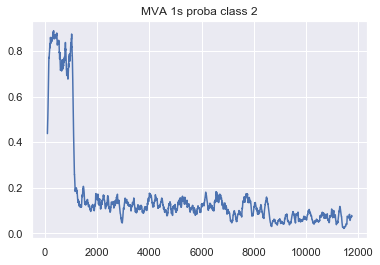

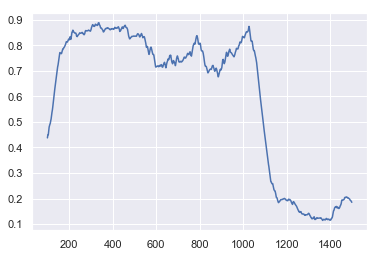

Wall time: 4min 58s


In [715]:
%%time
frame_length=882
hop_length=220
# frame_length=2048 #default nummer
# hop_length=512
df_res_1=run_model_test(df_speech_all,df_music_all,df_silence,frame_length,hop_length,100)

1128


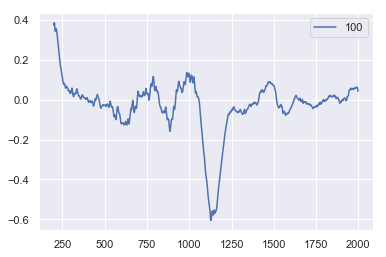

In [716]:
print(get_right_index_time(df_res_1,"avg_proba_2",100)) #1 sec pour tous les 100 index =10ms * 100/1000
# print(get_right_index_time(df_res_1,"avg_proba_2",30)) #1.161 sec pour tous les 50 index = 23.22ms *50/1000

In [ ]:
# 11754 (stopping_index) ==> 117.54400000000001 sec (stopping time in the video)
# 1100 ==> 11 sec
# 8400 ==> 84 sec

# generic_reportage=11 #vers les 11sec
# hop_length_ms=10 #en ms
# stopping_gene=int((generic_reportage/hop_length_ms)*1000)
# stopping_gene

In [461]:
print("% generique",int(100*11.36/117.54))
print("% reportage", int(100*84.64/117.54))
print("% debat",int(100*(117.54-11.36-84.64)/117.54))

% generique 9
% reportage 72
% debat 18


## DETAILS

### MUSIC

##### Audio 1

In [11]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_music_WAV_1MG.wav"
df_global=generate_features(path_file,frame_length,hop_length)
df_global.head()

y shape= (739329,) sample_rate= 22050
final_df shape= (3361, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-457.213074,72.594193,-8.358953,-10.214363,-20.455742,-38.720108,-15.255545,-0.671309,-5.756799,7.137289,...,-23.472538,-4.229893,2.428630,6.744668,10.121354,6.891716,3.749262,1.792355,-2.057331,-2.914470
1,-447.539276,79.559204,-10.765603,-13.090599,-20.208855,-39.773712,-22.168201,-9.615310,-5.439889,16.089890,...,-24.810909,-4.948831,0.499123,5.969634,12.845551,10.474005,4.015046,-1.635514,-6.484459,-4.907940
2,-443.919342,78.300560,-15.252008,-11.387630,-16.640978,-35.841446,-18.900642,-10.169295,-5.205597,14.690092,...,-22.967299,-3.175108,0.017701,4.854291,11.475812,8.354374,2.810126,-1.845369,-5.517056,-3.228968
3,-439.735474,81.446678,-11.135822,-6.384363,-19.623491,-38.378746,-14.319616,-8.069438,-7.364631,9.683415,...,-24.813852,-3.836197,0.193373,5.482703,10.307931,5.501609,2.486483,0.795180,-1.710689,-0.057672
4,-441.641785,74.409378,-16.785299,-3.681684,-22.070116,-48.012428,-15.231082,-0.508766,-3.239008,9.377754,...,-25.012842,-4.122231,1.318487,8.516588,12.677244,4.798965,0.689956,0.667297,-0.733382,0.818993


##### Audio 2

In [12]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_music_MP3_1MG.mp3"
df_global=generate_features(path_file,frame_length,hop_length)
df_global.head()

C:\Users\Hanane\Anaconda3\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


y shape= (598068,) sample_rate= 22050
final_df shape= (2719, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-525.402588,35.884636,8.512740,-16.824112,-26.728615,-20.715853,-8.628742,-1.014746,-1.440655,-5.886340,...,-14.844234,-3.817471,4.971860,7.027703,3.684711,-0.312433,-1.160637,1.337008,3.192248,3.156561
1,-523.430237,37.750496,8.304307,-18.764553,-28.951859,-21.715210,-7.625276,1.887708,2.553452,-2.089733,...,-15.618757,-3.480982,6.263111,8.661354,4.942968,0.015029,-1.982458,-0.402478,1.418019,1.952929
2,-518.355286,43.161610,9.363823,-22.267193,-34.729065,-26.439024,-9.070216,3.688272,6.021829,1.559171,...,-18.329416,-4.103991,7.756978,11.162909,7.108843,1.128927,-1.901569,-1.123742,0.523301,1.234053
3,-516.061951,45.989956,11.177144,-21.714844,-35.518009,-28.222218,-10.439493,4.875739,10.791101,8.202941,...,-19.511950,-4.974065,7.825968,12.571618,9.408092,2.947387,-1.905108,-3.016170,-1.874780,-0.440458
4,-518.749451,42.988899,10.487394,-19.274075,-30.721428,-23.274065,-7.310392,5.974358,11.077868,8.734161,...,-17.373474,-3.959556,7.390790,11.284701,8.240471,2.446363,-1.817606,-2.606209,-1.474988,-0.147758


##### Audio 3

In [13]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_music_OOG_1MG.ogg"
df_global=generate_features(path_file,frame_length,hop_length)
df_global.head()

y shape= (1639401,) sample_rate= 22050
final_df shape= (7452, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-553.952271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,-553.952271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,-553.952271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,-553.952271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,-549.285400,5.817215,3.668399,0.698067,-2.348502,-4.721788,-5.862472,-5.541503,-3.909179,-1.442441,...,-2.709491,-2.44816,-1.599311,-0.394107,0.851199,1.82086,2.282648,2.145756,1.500624,0.760806


##### Audio 4

In [15]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_music_ff-16b-2c-44100hz.wav"
df_global=generate_features(path_file,frame_length,hop_length)
df_global.head()
# https://docs.espressif.com/projects/esp-adf/en/latest/design-guide/audio-samples.html#sample-rates

y shape= (4125260,) sample_rate= 22050
final_df shape= (18752, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-557.014404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-557.014404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-557.014404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-467.646332,81.506927,5.722287,-16.409792,5.398256,9.092243,-12.753277,-21.447956,-8.804811,1.596754,...,-14.51534,-1.144909,-2.822786,-5.894633,-1.104251,5.748001,7.745937,5.556542,3.570024,2.378224
4,-397.844116,136.460876,-0.047653,-25.460102,8.971619,2.230145,-24.289309,-23.723389,-9.292258,-0.236128,...,-25.94422,-2.079306,-2.978750,-6.248129,1.006450,8.360593,8.354601,5.184776,2.846520,1.170444


### SPEECH

##### Speech 1

In [20]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_speech_1.wav"
df_speech1=generate_features(path_file,frame_length,hop_length)
df_speech1.head()

y shape= (220568,) sample_rate= 22050
final_df shape= (1003, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-529.024902,77.931412,-17.727821,15.452541,-1.411244,-1.214262,6.149488,1.250912,-2.707364,1.385819,...,-14.197477,3.108782,-2.084253,-0.012707,-0.365669,-1.541678,2.046653,1.216390,-0.535830,-1.190398
1,-504.290466,99.133789,-15.668314,12.842841,-2.506995,-0.326925,4.607704,1.893504,2.843008,1.086656,...,-18.576012,2.738227,-1.478397,1.292043,0.106247,-1.361807,-0.084355,-1.263845,-1.486235,-1.468332
2,-500.295380,103.735741,-18.979069,15.975704,2.933301,-8.640730,0.053574,1.951604,1.225374,1.665539,...,-20.284058,1.344885,-3.092793,0.717648,2.178434,0.102503,0.701893,-1.692468,-3.183159,-3.492883
3,-515.220337,88.802307,-25.254131,17.864326,1.116526,-6.128300,-1.254937,-2.057672,2.387785,7.283050,...,-16.349056,2.400576,-4.221546,0.661315,3.046542,2.633059,3.373439,-1.757303,-4.865284,-5.371016
4,-511.122803,90.696335,-21.376095,15.934320,-3.050010,1.191825,0.580305,0.028238,10.487341,6.620780,...,-16.068293,2.917031,-2.818185,2.591111,2.076494,0.461147,0.450978,-3.066893,-2.903941,-2.311953


##### Speech 2

In [22]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_speech_2.wav"
df_global=generate_features(path_file,frame_length,hop_length)
df_global.head()

y shape= (211660,) sample_rate= 22050
final_df shape= (963, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-574.381104,92.306335,16.976593,16.385345,10.291565,4.722518,8.224840,7.771517,-6.717768,-0.288058,...,-18.185266,-2.916633,-1.929438,-3.096967,-2.496376,-2.124489,0.273388,2.703081,1.145954,0.428776
1,-560.097656,106.375717,17.056570,11.630543,7.127902,5.225585,5.565197,7.936566,-3.860433,-4.609749,...,-21.222893,-2.938771,-0.895066,-1.926569,-2.909630,-3.218368,-1.770125,1.450453,1.781015,1.356167
2,-559.681641,111.780434,14.708793,7.713719,9.142885,9.429110,4.762301,7.732823,-0.455288,-9.485945,...,-21.026855,-1.817759,-0.434238,-2.089263,-4.304770,-3.678554,-3.255447,-0.285181,1.351274,0.582345
3,-557.721558,107.681473,12.839108,12.996616,7.735577,4.749811,3.666955,8.054562,2.551147,-3.500478,...,-21.096685,-2.659111,-1.395273,-0.706411,-1.761639,-1.586532,-2.276066,-0.807769,-0.001552,-0.572218
4,-560.303284,98.260933,11.719090,14.954180,5.337455,3.256258,3.517576,3.989910,0.503334,4.782918,...,-19.639099,-2.810095,-2.374842,-0.893459,0.003908,0.344178,-0.844504,-1.193101,-2.001705,-1.289126


##### Speech 3

In [19]:
frame_length=882
hop_length=220
path_file="../sample_audio/audio_speech_3.wav"
df_global=generate_features(path_file,frame_length,hop_length)
df_global.head()
# https://www.signalogic.com/index.pl?page=speech_codec_wav_samples
# https://www.signalogic.com/melp/FrenchSamples/Orig/f_m.wav

y shape= (583653,) sample_rate= 22050
final_df shape= (2653, 26)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,d_mfcc4,d_mfcc5,d_mfcc6,d_mfcc7,d_mfcc8,d_mfcc9,d_mfcc10,d_mfcc11,d_mfcc12,d_mfcc13
0,-544.613281,36.229950,26.388344,18.794758,15.292778,12.900145,8.092622,1.040428,-4.688881,-7.464811,...,-5.775517,-4.248606,-4.270882,-5.182303,-5.351141,-4.075154,-1.814545,0.415806,1.347559,1.293796
1,-540.255615,41.848801,29.634119,17.530603,9.325331,5.268041,3.801402,2.715643,0.762321,-1.875905,...,-9.347031,-6.392800,-3.515385,-1.967842,-1.732697,-2.048720,-1.912184,-0.807769,0.184117,0.662669
2,-533.851990,49.795410,34.668312,19.477337,9.654413,5.055714,3.120503,2.055634,1.257535,0.648123,...,-11.449329,-7.751724,-4.137732,-1.979384,-1.067815,-0.704702,-0.493407,-0.403785,-0.300947,-0.208096
3,-533.235229,49.668617,32.905197,17.627670,9.664970,7.657586,7.548241,6.278768,3.202610,0.498598,...,-10.726229,-6.068400,-2.481453,-1.430354,-1.866361,-1.889823,-0.603398,1.192120,1.969841,1.533792
4,-532.045471,50.578484,32.498207,16.952787,9.492419,6.714770,4.056611,1.155158,-0.262457,0.157615,...,-11.073321,-6.712121,-3.703107,-2.506937,-1.743338,-0.607415,0.596830,1.397238,1.370070,0.924870


### DETAILS TESTED FILES

In [ ]:
# speech_files=['audio_speech_1.wav','audio_speech_2.wav','audio_speech_3.wav','audio_speech_alors.wav','audio_speech_gros_loup.wav']

#only female ==> ca ne fonctionne pas
# speech_files=['french14.mp3','french59.mp3','french60.mp3','french62.mp3']

#female french14 french59 french60 french62 french16 french50 french26
#Moins bien pour la partie générique
# speech_files=['french14.mp3','french15.mp3','french45.mp3','french59.mp3','french60.mp3','french62.mp3','french16.mp3'
#               ,'french50.mp3','french26.mp3','french31.mp3','french43.mp3','french49.mp3'
#              ]

#female french14 french59 french60 
#male 'french15.mp3','french45.mp3' 'french31.mp3'
# ==> ca ne fonctionne pas
# speech_files=['french14.mp3','french59.mp3','french60.mp3','french15.mp3','french45.mp3','french31.mp3']

#ça ne fonctionne pas trop
# speech_files=['french14.mp3','french29.mp3','french44.mp3','french59.mp3','french60.mp3','french62.mp3']

# speech_files=['french'+str(i)+".mp3" for i in range(10,25)]

#n'est pas suffisant
# speech_files=['french10.mp3','french11.mp3','french12.mp3','french13.mp3']

# ça donne un 2 net au début de la vidéo,avec un décrochage au niveau de la 11S, par contre beaucoup de variation après ce temps
# speech_files=['french10.mp3','french11.mp3','french12.mp3','french13.mp3','french14.mp3','french15.mp3','french45.mp3','french59.mp3','french60.mp3','french62.mp3']

# ça ne fonctionne pas du tout
# fr-sb-71.wav
# speech_files=["fr-sb-"+str(i)+".wav" for i in range(71,81)]

### MUSIC FILES

In [481]:
# 'audio_music_ff-16b-2c-44100hz.wav' ==> 18752
# 'audio_music_Kalimba-online-audio-converter.com_-1.wav' ==> 34885
# 'audio_music_MP3_1MG.mp3' ==>2719

# music_files=['audio_music_ff-16b-2c-44100hz.wav','audio_music_Kalimba-online-audio-converter.com_-1.wav'
#               ,'audio_music_MP3_1MG.mp3','audio_music_OOG_1MG.ogg','audio_music_WAV_1MG.wav']

# music_files=['audio_music_ff-16b-2c-44100hz.wav','audio_music_MP3_1MG.mp3'] #==> ça a bien fonctionné

# music_files=['audio_music_Kalimba-online-audio-converter.com_-1.wav','audio_music_MP3_1MG.mp3']